In [0]:

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
print(os.listdir("drive"))

import pandas as pd
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

from skimage import io

import pickle
import h5py
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation,Dropout,BatchNormalization
from keras.models import Model
from keras.models import model_from_json
from scipy.misc import imread, imresize,imshow
import keras.models

%matplotlib inline


In [0]:
path_dir='drive/digit_recoginzer'
path_train_a=glob.glob(os.path.join(path_dir,'training-a','*.png'))
path_train_b=glob.glob(os.path.join(path_dir,'training-b','*.png'))
path_train_c=glob.glob(os.path.join(path_dir,'training-c','*.png'))
path_train_d=glob.glob(os.path.join(path_dir,'training-d','*.png'))
path_train_e=glob.glob(os.path.join(path_dir,'training-e','*.png'))


In [0]:
path_train_label_a=os.path.join(path_dir,'training-a.csv')
path_train_label_b=os.path.join(path_dir,'training-b.csv')
path_train_label_c=os.path.join(path_dir,'training-c.csv')
path_train_label_d=os.path.join(path_dir,'training-d.csv')
path_train_label_e=os.path.join(path_dir,'training-e.csv')


In [0]:
def read_image(path):
    img=io.imread(path,as_gray=True)
    return img
def get_key(path):
    key=path.split(sep=os.sep)[-1]
    return key
def get_data(path_img,path_label,resize_dim):
    ii=path_label.split('-')[-1][0]
    try:
        #to check if data is already prepared and saved in .h5 format
        pat='drive/digit_recoginzer/data'+ii+'.h5'
        hf=h5py.File(pat,'r')
        X=np.array(hf["X"][:]) 
        Y=np.array(hf["Y"][:]) 
        
    except:
        X=[]
        Y=[]
        for i,path in enumerate(path_img):
            img=read_image(path)
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA)
            gaussian_3=cv2.GaussianBlur(img,(9,9),10.0)
            img=cv2.addWeighted(img,1.5,gaussian_3,-0.5,0,img)
            kernel=np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]]) #filter
            img=cv2.filter2D(img,-1,kernel)
            X.append(img)
            if i==len(path_img)-1:
                end='\n'
            else:
                end='\r'
            print('processed {}/{}'.format(i+1,len(path_img)),end=end)
        X=np.array(X)
        
        df=pd.read_csv(path_label)
        df=df.set_index('filename')
        y=[df.loc[get_key(path)]['digit'] for path in path_img ]
        #y=to_categorical(y,10)
        
        #for i,path in enumerate(path_label):
            #df=pd.read_csv(path)
            #df=df.set_index('filename')
            #pp=glob.glob(os.path.join(path_all[i],'*.png'))
            #y=[df.loc[get_key(path1)]['digit'] for path1 in pp]
        y=to_categorical(y,10)
        #Y.append(y)
        Y=np.array(Y)
        pat='drive/digit_recoginzer/data'+ii+'.h5'
        hf=h5py.File(pat,'w')
        hf.create_dataset('X',data=X,compression="gzip",compression_opts=9)
        hf.create_dataset('Y',data=Y,compression="gzip",compression_opts=9)
        hf.close()
    
    return X,Y

In [0]:
trainX_a,trainY_a=get_data(path_train_a,path_train_label_a,32)
trainX_b,trainY_b=get_data(path_train_b,path_train_label_b,32)
trainX_c,trainY_c=get_data(path_train_c,path_train_label_c,32)
trainX_d,trainY_d=get_data(path_train_d,path_train_label_d,32)
trainX_e,trainY_e=get_data(path_train_e,path_train_label_e,32)

In [0]:
trainX_a.shape,trainX_b.shape

((19702, 32, 32), (359, 32, 32))

In [0]:
trainY_a.shape,trainY_b.shape

((19702, 10), (359, 10))

In [0]:
trainX=np.concatenate((trainX_a,trainX_b,trainX_c,trainX_d,trainX_e),axis=0)
trainY=np.concatenate((trainY_a,trainY_b,trainY_c,trainY_d,trainY_e),axis=0)

In [0]:
trainX.shape,trainY.shape

((72045, 32, 32), (72045, 10))

In [0]:
trainX=trainX.reshape(trainX.shape[0],32,32,1).astype('float32')

trainX=trainX/255
trainX.shape

(72045, 32, 32, 1)

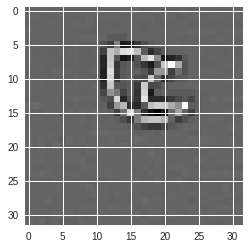

In [0]:
xx=45678

plt.imshow(trainX[xx,:,:,0])

In [0]:
indices=list(range(len(trainX)))
np.random.seed(0)
np.random.shuffle(indices)

ind=int(len(trainX)*.80)
train_X=trainX[indices[:ind]]
val_X=trainX[indices[ind:]]

train_Y=trainY[indices[:ind]]
val_Y=trainY[indices[ind:]]

In [0]:
train_X.shape,train_Y.shape,val_X.shape,val_Y.shape

((57636, 32, 32, 1), (57636, 10), (14409, 32, 32, 1), (14409, 10))

In [0]:
def model_rec():
    model=Sequential()
    model.add(Conv2D(8,(5,5),input_shape=(32,32,1),activation='relu',padding='same',name='conv1'))
    model.add(MaxPooling2D(pool_size=(2,2),name='max1'))
    
    model.add(Conv2D(16,(3,3),activation='relu',padding='same',name='conv3'))
    model.add(MaxPooling2D(pool_size=(2,2),name='max2'))
    
    model.add(Conv2D(32,(3,3),activation='relu',padding='same',name='conv5'))
    model.add(MaxPooling2D(pool_size=(2,2),name='max3'))
    
    model.add(Conv2D(64,(3,3),activation='relu',padding='same',name='conv6'))
    model.add(MaxPooling2D(pool_size=(2,2),name='max4'))
    
    model.add(Flatten())
    model.add(Dense(64,activation='relu',name='dense1'))
    
    model.add(Dense(10,activation='softmax',name='dense2'))
    
    return model

In [0]:
mymodel=model_rec()

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
mymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 8)         208       
_________________________________________________________________
max1 (MaxPooling2D)          (None, 16, 16, 8)         0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 16)        1168      
_________________________________________________________________
max2 (MaxPooling2D)          (None, 8, 8, 16)          0         
_________________________________________________________________
conv5 (Conv2D)               (None, 8, 8, 32)          4640      
_________________________________________________________________
max3 (MaxPooling2D)          (None, 4, 4, 32)          0         
_________________________________________________________________
conv6 (Conv2D)               (None, 4, 4, 64)          18496     
__________

In [0]:
from keras.optimizers import Adam

opt=Adam(lr=1e-3)
mymodel.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
mymodel.fit(x=train_X,
            y=train_Y,
            batch_size=64,
            verbose=1,
            epochs=100,
            validation_data=(val_X,val_Y),
            shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 57636 samples, validate on 14409 samples
Epoch 1/100
57636/57636 [==============================] - 14s 247us/step - loss: 1.4697 - acc: 0.5261 - val_loss: 1.1263 - val_acc: 0.6931
Epoch 2/100
57636/57636 [==============================] - 10s 177us/step - loss: 0.8540 - acc: 0.7535 - val_loss: 0.6152 - val_acc: 0.8196
Epoch 3/100
57636/57636 [==============================] - 10s 179us/step - loss: 0.4420 - acc: 0.8654 - val_loss: 0.3852 - val_acc: 0.8810
Epoch 4/100
57636/57636 [==============================] - 10s 179us/step - loss: 0.2948 - acc: 0.9095 - val_loss: 0.2889 - val_acc: 0.9139
Epoch 5/100
57636/57636 [==============================] - 10s 177us/step - loss: 0.2243 - acc: 0.9309 - val_loss: 0.2677 - val_acc: 0.9227
Epoch 6/100
57636/57636 [==============================] - 10s 177us/step - loss: 0.1866 - acc: 0.9426 - val_loss: 0.2471 - val_acc: 0.9264
Epoch 7/100
57636/57636 [==============================] - 10s

In [0]:
loss,acc=mymodel.evaluate(val_X,val_Y)
print("Loss = "+str(loss))
print("Test Accuracy = "+str(acc))



14409/14409 [==============================] - 1s 85us/step
Loss = 0.28141012726913184
Test Accuracy = 0.9615518078978417


In [0]:
#save model

model_json=mymodel.to_json()
with open("drive/digit_recoginzer/model.json","w") as json_file:
    json_file.write(model_json)

mymodel.save_weights("drive/digit_recoginzer/model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
#load model

json_file=open('drive/digit_recoginzer/model.json','r')
loaded_model_json=json_file.read()
json_file.close()
loaded_model=model_from_json(loaded_model_json)
#load woeights into new model
loaded_model.load_weights("drive/digit_recoginzer/model.h5")
print("Loaded Model from disk")

#compile and evaluate loaded model
loaded_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])



Loaded Model from disk


In [0]:
loss,acc=loaded_model.evaluate(val_X,val_Y)
print("Loss = "+str(loss))
print("Test Accuracy = "+str(acc))

In [0]:
names = [weight.name for layer in loaded_model.layers for weight in loaded_model.weights]
weights = loaded_model.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)

conv1_1/kernel:0 (5, 5, 1, 8)
conv1_1/bias:0 (8,)
conv3_1/kernel:0 (3, 3, 8, 16)
conv3_1/bias:0 (16,)
conv5_1/kernel:0 (3, 3, 16, 32)
conv5_1/bias:0 (32,)
conv6_1/kernel:0 (3, 3, 32, 64)
conv6_1/bias:0 (64,)
dense1_1/kernel:0 (256, 64)
dense1_1/bias:0 (64,)
dense2_1/kernel:0 (64, 10)
dense2_1/bias:0 (10,)


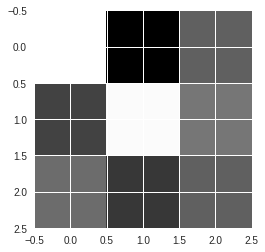

In [0]:
x=weights[4]
x=x.reshape(32,3,3,16)
plt.imshow(x[23,:,:,0])